# Train and register an ONNX model with AutoML
---
---

## Contents
1. [Introduction](#Introduction)
2. [Setup](#Setup)
3. [Data](#Data)
4. [Train](#Train)
5. [Synape Link to Azure ML](#SynapeLinktoAzureML)
6. [Confusion Matrix](#ConfusionMatrix)
7. [Model Explaination](#ModelExplaination)

---

## Introduction
Azure Machine Learning provides capabilities to control all aspects of model training and deployment directly from a notebook using the AML Python SDK.  In this notebook we will
* connect to our AML Workspace
* create an experiment that contains all runs
* Run AutoML to find the best model 
* Save the AutoML model as ONNX
* Register the ONNX Model 

In the end the ONNX Model will be accessible through Synapse Link to Azure Machine Learning

---

## Setup
Create an Azure Machine Learning servcie in Azure, and launch the studio. 

Create a Workspace, a Compute Instance (VM) and a new Notebook running on that VM as a compute target.  

This example was forked from https://github.com/Azure/MachineLearningNotebooks, and further developed to present an end-to-end example. 

For this notebook we need the Azure ML SDK and access to our workspace.  The following cell imports the SDK, checks the version, and accesses our already configured AzureML workspace. 

See more detail on [Git Integration](https://docs.microsoft.com/en-us/azure/machine-learning/concept-train-model-git-integration#:~:text=Azure%20Machine%20Learning%20provides%20a%20shared%20file%20system,work%20with%20Git%20via%20the%20Git%20CLI%20experience) if you need to upload this notebook in AML.

In [1]:
import azureml.core
from azureml.core import Experiment, Workspace

# Check core SDK version number
print("This notebook was created using version 1.0.2 of the Azure ML SDK")
print("You are currently using version", azureml.core.VERSION, "of the Azure ML SDK")
print("")


ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')

This notebook was created using version 1.0.2 of the Azure ML SDK
You are currently using version 1.29.0 of the Azure ML SDK

Workspace name: workspacers
Azure region: westus
Subscription id: 61489282-e75d-4996-b2ef-3126311e55e6
Resource group: ramsoft


---

## Data
We will use the diabetes dataset for this experiement (https://aka.ms/diabetes-data). 

The dataset consists of 8 baseline variables for n=10000 diabetes patients: Pregnancies, PlasmaGlucose, DiastolicBloodPressure, TricepsThickness, SerumInsulin, BMI, DiabetesPedigree, and Age.

The dataset has one dichotomous outcome variable: Diebetic.

In [2]:
from azureml.core import Dataset
import pandas as pd
from sklearn.model_selection import train_test_split

# load the diabetes dataset from the same folder where this notebook is located
print("Loading Diabetes Data from the CSV file...")
dataset = pd.read_csv('./diabetes.csv')

# Separate features and labels
X, y = dataset[['Pregnancies','PlasmaGlucose','DiastolicBloodPressure','TricepsThickness','SerumInsulin','BMI','DiabetesPedigree','Age']].values, dataset['Diabetic'].values
# Split data into training set and test set (80% Training and 20% Testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

data = {
    "train":{"X": X_train, "y": y_train},        
    "test":{"X": X_test, "y": y_test}
}

print ("Data contains", len(data['train']['X']), "training samples and",len(data['test']['X']), "test samples")


Loading Diabetes Data from the CSV file...
Data contains 8000 training samples and 2000 test samples


---
## Train

Let's use AutoML to train the dataset. There are two prerequisits for onnx:

1- Use tablular dataset to point to the CSV file (https path required)

2- Remote compute target will be required.

In [3]:
# CSV URL required (public https URL)

# The url for this AML Workspace below is not public and will not work. Hence will us the GitHub RAW URL
# csv_path = 'https://ml.azure.com/fileexplorerAzNB?wsid=/subscriptions/61489282-e75d-4996-b2ef-3126311e55e6/resourcegroups/Ramsoft/workspaces/workspacers&tid=72f988bf-86f1-41af-91ab-2d7cd011db47&activeFilePath=Users/mualdurr/AzureMachineLearning/diabetescsv-automl-onnx-synapse/diabetes.csv'

csv_path = 'https://raw.githubusercontent.com/MustAl-Du/AzureMachineLearning/main/diabetescsv-regression-aks-drift/diabetes.csv'
csv_path


'https://raw.githubusercontent.com/MustAl-Du/AzureMachineLearning/main/diabetescsv-regression-aks-drift/diabetes.csv'

In [4]:
# Current compute target name
computetarget_name = 'computeinstancers'
computetarget_name

'computeinstancers'

In [5]:
# Make the existing compute instance as the comptue target
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=computetarget_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D2_V2',
                                                           max_nodes=6)
    compute_target = ComputeTarget.create(ws, computetarget_name, compute_config)

compute_target.wait_for_completion(show_output=True)

Found existing cluster, use it.

Running


In [6]:
import logging
from azureml.train.automl import AutoMLConfig
from azureml.widgets import RunDetails

dataset = Dataset.Tabular.from_delimited_files(csv_path)
training_data, validation_data = dataset.random_split(percentage=0.8, seed=223)


# Get an experiment object from Azure Machine Learning
experiment = Experiment(workspace=ws, name="diabetes-automl-onnx")

# Create a run object in the experiment
run =  experiment.start_logging()


automl_settings = {
    "n_cross_validations": 3,
    "primary_metric": 'AUC_weighted',
    "experiment_timeout_minutes": 17,
    "experiment_timeout_hours": 0.25, # This is a time limit for testing purposes, remove it for real use cases, this will drastically limit ability to find the best model possible
    "verbosity": logging.INFO,
    "enable_stack_ensemble": False
}

automl_config = AutoMLConfig(task = 'classification',
                             debug_log = 'automl_errors.log',
                             compute_target=compute_target,
                             enable_onnx_compatible_models=True, # must be explicitly declared for onnx
                             blocked_models = ['KNN','LinearSVM'], # example of skipping a few algorithms
                             training_data = training_data,
                             label_column_name = 'Diabetic', # the output label 
                             **automl_settings
                            )

local_run = experiment.submit(automl_config, show_output = True)

RunDetails(local_run).show()

Submitting remote run.
No run_configuration provided, running on computeinstancers with default configuration
Running on remote compute: computeinstancers


Experiment,Id,Type,Status,Details Page,Docs Page
diabetes-automl-onnx,AutoML_b03ac74a-f719-41c6-9661-fbd785482b0c,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation



Current status: FeaturesGeneration. Generating features for the dataset.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and all classes are balanced in your training data.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData

****************************************************************************************************

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were detected in the training data.
              Learn more about missing value imputation: https://aka.ms/AutomatedMLFeaturization

****************************************************************************************************

TYPE:         High cardinality feature detection
STATUS

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

In [7]:
# Get the best fitted model
best_run, fitted_model = local_run.get_output()
fitted_model

Pipeline(memory=None,
         steps=[('datatransformer',
                 DataTransformer(enable_dnn=False, enable_feature_sweeping=False, feature_sweeping_config={}, feature_sweeping_timeout=86400, featurization_config=None, force_text_dnn=False, is_cross_validation=True, is_onnx_compatible=True, observer=None, task='classification', working_dir='/mnt/batch/tasks/shared/LS_root/mount...
    subsampling_schedule='hyperband_clip',
    cost_mode_param=None,
    iteration_timeout_mode=0,
    iteration_timeout_param=None,
    feature_column_names=None,
    label_column_name=None,
    weight_column_name=None,
    cv_split_column_names=None,
    enable_streaming=None,
    timeseries_param_dict=None,
    gpu_training_param_dict={'processing_unit_type': 'cpu'}
), random_state=None))],
         verbose=False)

In [9]:
# Retrieve and save the ONNX format of the best fitted model
from azureml.automl.runtime.onnx_convert import OnnxConverter

best_run, onnx_mdl = local_run.get_output(return_onnx_model=True)
onnx_filepath = "./best_fitted_model.onnx"
OnnxConverter.save_onnx_model(onnx_mdl, onnx_fl_path)

In [10]:
# Register the Model in AML for later reference in Synapse
from azureml.core import Model

model = Model.register(model_path = onnx_filepath,
                       model_name = "DiabeticONNXModel",
                       model_framework=Model.Framework.ONNX ,  
                       tags = {"onnx":"V0"},
                       description = "DiabeticONNXModel",
                       workspace = ws)

Registering model DiabeticONNXModel


## Synape Link to Azure ML

Create a Service Principal, add it to AML workspace: https://docs.microsoft.com/en-us/azure/synapse-analytics/machine-learning/quickstart-integrate-azure-machine-learning

In Synapse Studio link to this AML: https://docs.microsoft.com/en-us/azure/synapse-analytics/machine-learning/tutorial-sql-pool-model-scoring-wizard. You could follow that example and modify to this diebetes dataset and onnx model. In essence, it does thse three steps:

1- Upload the diebetes.csv file in Synapse primary storage account (or access it from AML storage after granting access rights)

2- Create a table in Synapse Dedicated SQL Pool and populate it from teh csv file (see [CreateInsertDiabeticTable.sql](./CreateInsertDiabeticTable.sql))

3- Right-click the table->Machine Leanring->Enrich with Exsiting model. Choose your Azure ML workspace and the registered ONNX Model.

4- The Wizard would create a table to host the model, and a stored procedure to run the prediction. Follow this mapping between the Diabetic table and ONNX Model:
<img src="./MappingModelColumns.PNG">

5- Execute the Stored Procedure [PredictDiabetic](./PredictDiabetic.sql) to see the predictions
6- Y

## Confusion Matrix 

Creating a confusion matrix

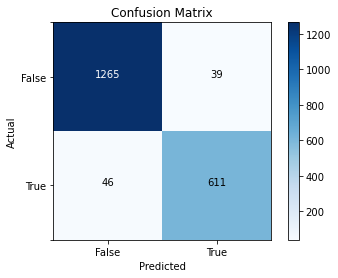

In [14]:
# Create confusion matrix (dataset needs to be in dataframes)
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools
from matplotlib import pyplot as plt


# convert the test data to dataframe
X_test_df = validation_data.drop_columns(columns=['Diabetic']).to_pandas_dataframe()
y_test_df = validation_data.keep_columns(columns=['Diabetic'], validate=True).to_pandas_dataframe()
# call the predict functions on the model
y_pred = fitted_model.predict(X_test_df)
y_pred



cf =confusion_matrix(y_test_df.values,y_pred)
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
class_labels = ['False','True']
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks,class_labels)
plt.yticks([-0.5,0,1,1.5],['','False','True',''])
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show()

## Model Explaination

Creating Model Explaination

In [15]:
# Run explaination
from azureml.interpret import ExplanationClient

client = ExplanationClient.from_run(best_run)
engineered_explanations = client.download_model_explanation(raw=False)
print(engineered_explanations.get_feature_importance_dict())
print("You can visualize the engineered explanations under the 'Explanations (preview)' tab in the AutoML run at:-\n" + best_run.get_portal_url())

{'Pregnancies_CharGramCountVectorizer_0': 1.1321782323640355, 'Age_MeanImputer': 1.0322976263149477, 'BMI_MeanImputer': 0.727508724407809, 'SerumInsulin_MeanImputer': 0.5866519529391103, 'Pregnancies_CharGramCountVectorizer_1': 0.5810706848409658, 'PlasmaGlucose_MeanImputer': 0.5160750599830192, 'TricepsThickness_MeanImputer': 0.34972182691550063, 'DiastolicBloodPressure_MeanImputer': 0.2611272498876044, 'DiabetesPedigree_MeanImputer': 0.1613902447235784, 'Pregnancies_CharGramCountVectorizer_2': 0.09453521663249033, 'Pregnancies_CharGramCountVectorizer_7': 0.08809144451042664, 'Pregnancies_CharGramCountVectorizer_4': 0.07928603250590224, 'Pregnancies_CharGramCountVectorizer_5': 0.0565211908807156, 'Pregnancies_CharGramCountVectorizer_6': 0.056453559674081236, 'Pregnancies_CharGramCountVectorizer_3': 0.04458805551928376, 'Pregnancies_CharGramCountVectorizer_10': 0.02556915339759299, 'PatientID_MeanImputer': 0.016372154376765504, 'Pregnancies_CharGramCountVectorizer_13': 0.00623180700535